# Bibliotheken importieren

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
import plotly.express as px

# Daten einlesen und überblick über die Daten

In [2]:
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")


print("Aperçu du fichier train:")
display(df_train.head())

print("\nAperçu du fichier test:")
display(df_test.head())


Aperçu du fichier train:


,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
4,462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6,A



Aperçu du fichier test:


,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,458989,Female,Yes,36,Yes,Engineer,0.0,Low,1.0,Cat_6,B
1,458994,Male,Yes,37,Yes,Healthcare,8.0,Average,4.0,Cat_6,A
2,458996,Female,Yes,69,No,NaN,0.0,Low,1.0,Cat_6,A
3,459000,Male,Yes,59,No,Executive,11.0,High,2.0,Cat_6,B
4,459001,Female,No,19,No,Marketing,NaN,Low,4.0,Cat_6,A


In [3]:
df_test.info()
df_train.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2627 entries, 0 to 2626
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               2627 non-null   int64  
 1   Gender           2627 non-null   object 
 2   Ever_Married     2577 non-null   object 
 3   Age              2627 non-null   int64  
 4   Graduated        2603 non-null   object 
 5   Profession       2589 non-null   object 
 6   Work_Experience  2358 non-null   float64
 7   Spending_Score   2627 non-null   object 
 8   Family_Size      2514 non-null   float64
 9   Var_1            2595 non-null   object 
 10  Segmentation     2627 non-null   object 
dtypes: float64(2), int64(2), object(7)
memory usage: 225.9+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8068 entries, 0 to 8067
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               8068 non-n

In [4]:
# Verkettung der beiden Dateien, da sie die gleiche Anzahl an Spalten haben, und Zusammenführung aller Daten für ein globales Clustering.
df = pd.concat([df_train, df_test], ignore_index=True) 
df.head() 

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
4,462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6,A


# Vorbearbeitung der Daten

In [5]:
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10695 entries, 0 to 10694
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               10695 non-null  int64  
 1   Gender           10695 non-null  object 
 2   Ever_Married     10505 non-null  object 
 3   Age              10695 non-null  int64  
 4   Graduated        10593 non-null  object 
 5   Profession       10533 non-null  object 
 6   Work_Experience  9597 non-null   float64
 7   Spending_Score   10695 non-null  object 
 8   Family_Size      10247 non-null  float64
 9   Var_1            10587 non-null  object 
 10  Segmentation     10695 non-null  object 
dtypes: float64(2), int64(2), object(7)
memory usage: 919.2+ KB
None
                  ID           Age  Work_Experience   Family_Size
count   10695.000000  10695.000000      9597.000000  10247.000000
mean   463468.088640     43.511828         2.619777      2.844052
std      2600.966411     1

In [6]:
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)

In [7]:
df['Gender'] = df['Gender'].map({'Male': 0, 'Female': 1})

# Auswahl der für das clustering relevanten variablen

In [12]:
# Exemple de conversion en scores numériques (à adapter selon les valeurs)
score_map = {
    'Low': 1,
    'Average': 2,
    'High': 3
}
df['Spending_Score_Num'] = df['Spending_Score'].map(score_map)


In [13]:
X = df[['Age', 'Work_Experience', 'Family_Size', 'Spending_Score_Num']].dropna()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Wahl der optimalen Anzahl von Clustern mit der Elbow Method

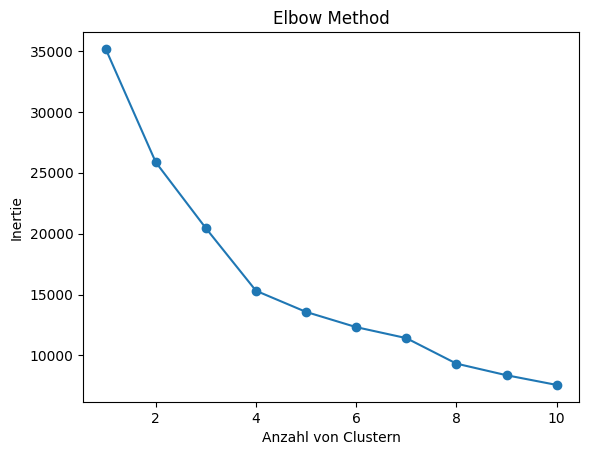

In [15]:
inertia = []
range_n = range(1, 11)

for k in range_n:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.plot(range_n, inertia, marker='o')
plt.xlabel('Anzahl von Clustern')
plt.ylabel('Inertie')
plt.title("Elbow Method")
plt.show()

# Clustering KMeans mit K= 5

In [16]:
kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(X_scaled)
df['Cluster'] = clusters

# Visualisation 2D mit PCA 

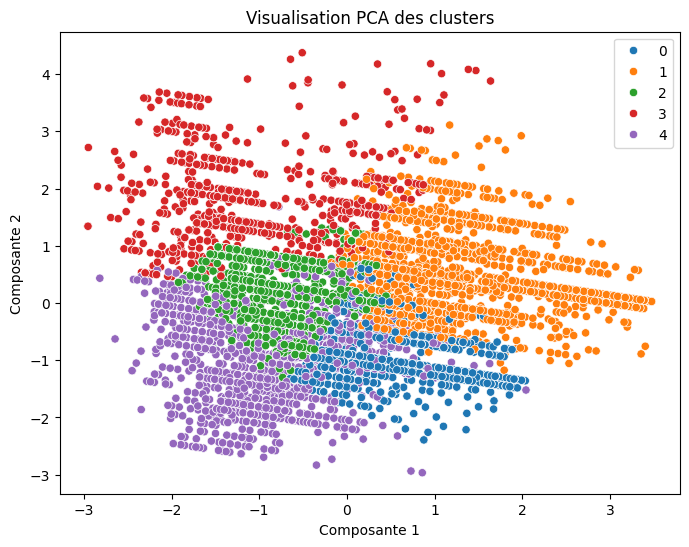

In [17]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=clusters, palette='tab10')
plt.title("Visualisation PCA des clusters")
plt.xlabel("Composante 1")
plt.ylabel("Composante 2")
plt.show()

# Visualization mit t-SNE

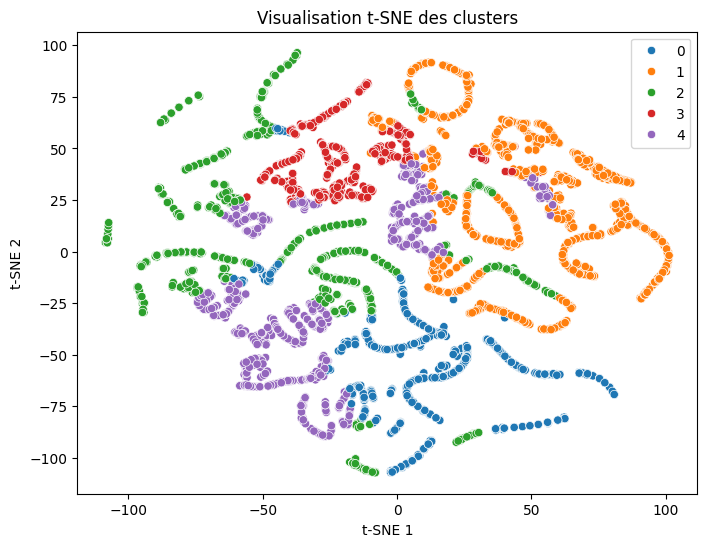

In [18]:
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], hue=clusters, palette='tab10')
plt.title("Visualisation t-SNE von clusterns")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.show()

# Analyse von Clusterns

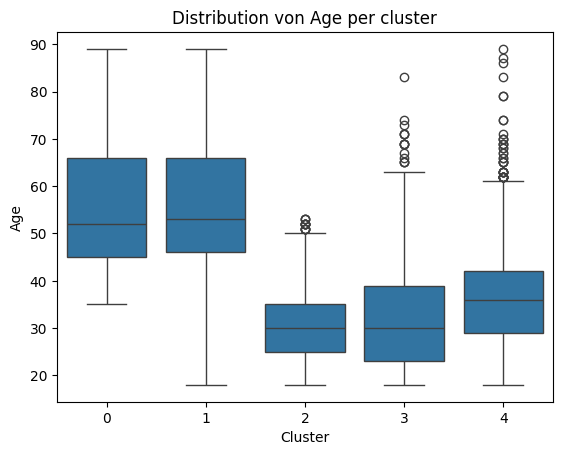

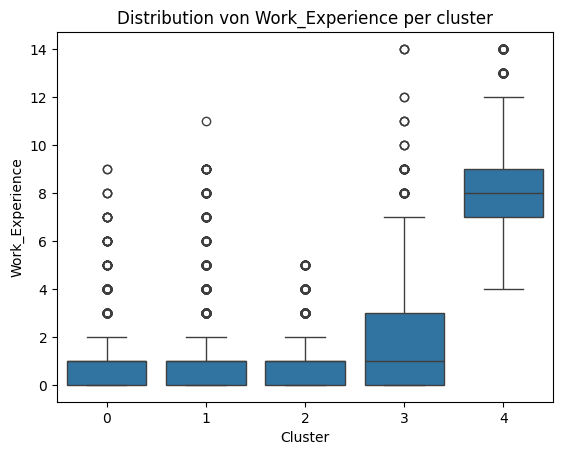

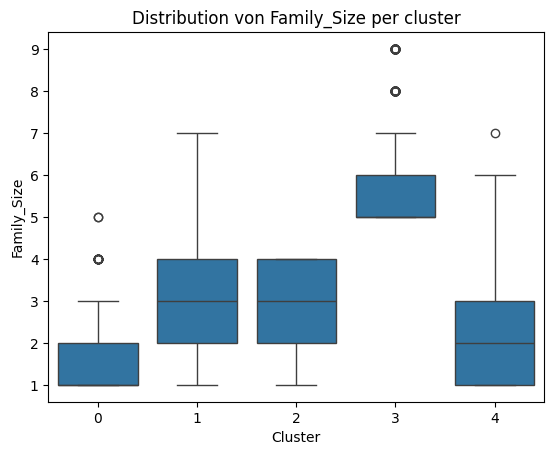

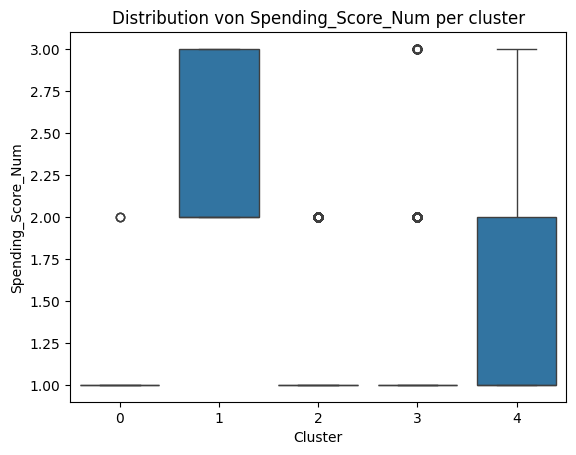

In [20]:
df.groupby('Cluster').mean(numeric_only=True)

# Visualisation von Karactéristiques per cluster
for col in ['Age', 'Work_Experience', 'Family_Size','Spending_Score_Num']:
    plt.figure()
    sns.boxplot(x='Cluster', y=col, data=df)
    plt.title(f'Distribution von {col} per cluster')
    plt.show()